<a href="https://colab.research.google.com/github/TAKE-JP-17/Pytorch/blob/main/1d_derivative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 500/5000, Loss: 1.360933
Epoch 1000/5000, Loss: 1.360933
Epoch 1500/5000, Loss: 1.360933
Epoch 2000/5000, Loss: 1.360933
Epoch 2500/5000, Loss: 1.360933
Epoch 3000/5000, Loss: 1.360933
Epoch 3500/5000, Loss: 1.360933
Epoch 4000/5000, Loss: 1.360933
Epoch 4500/5000, Loss: 1.360933
Epoch 5000/5000, Loss: 1.360933


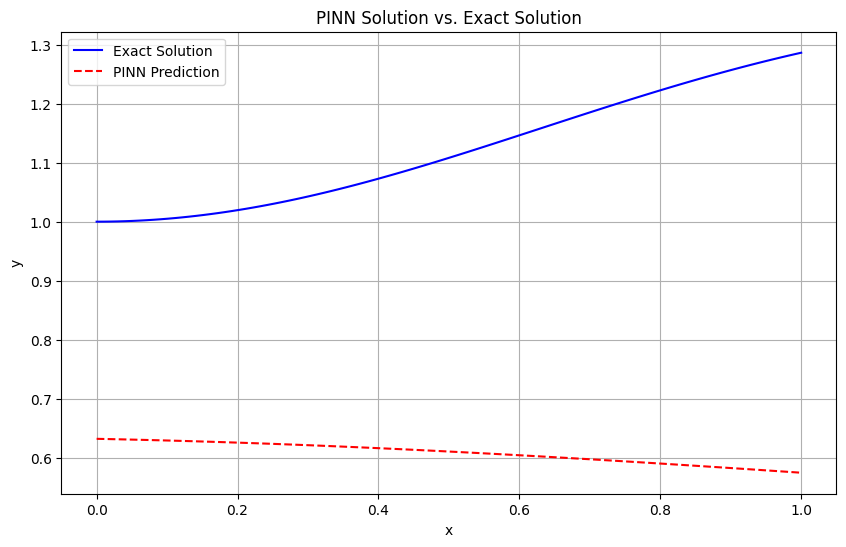

Mean Absolute Error (MAE): 0.512509


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Define the exact solution for comparison
def exact_solution(x):
    C = 1  # The constant for y(0) = 1
    integrand = lambda t: np.exp(t**2) * np.sin(t)
    integral, _ = quad(integrand, 0, x)
    return np.exp(-x**2) * integral + C

# Define the physics-informed neural network (PINN)
class PINN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=100, output_dim=1, num_hidden_layers=5):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        self.layers.append(nn.Tanh())
        for _ in range(num_hidden_layers):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.Tanh())
        self.layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Define loss function with higher boundary weight
def compute_loss(model, x_physics, x_boundary, y_boundary, lambda_physics=1.0, lambda_bc=10.0):
    x_physics.requires_grad = True
    y_physics = model(x_physics)
    dy_dx = torch.autograd.grad(y_physics, x_physics, torch.ones_like(y_physics), create_graph=True)[0]
    p = 2 * x_physics
    q = torch.sin(x_physics)
    physics_residual = dy_dx + p * y_physics - q
    physics_loss = torch.mean(physics_residual**2)

    y_boundary_pred = model(x_boundary)
    boundary_loss = torch.mean((y_boundary_pred - y_boundary)**2)

    total_loss = lambda_physics * physics_loss + lambda_bc * boundary_loss
    return total_loss

# Training parameters
epochs = 5000
learning_rate = 0.0005
x_physics = torch.cat([
    torch.linspace(0, 0.5, 80).view(-1, 1),
    torch.linspace(0.5, 1, 20).view(-1, 1)
], dim=0).float()
x_boundary = torch.tensor([[0.0]]).float()
y_boundary = torch.tensor([[1.0]]).float()

# Model, optimizer, and scheduler
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Initialize weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights)

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = compute_loss(model, x_physics, x_boundary, y_boundary)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.6f}")

# Plot results
x_test = torch.linspace(0, 1, 100).view(-1, 1).float()
y_pred = model(x_test).detach().numpy()
x_test_np = x_test.numpy().flatten()
y_exact = np.array([exact_solution(x) for x in x_test_np])

plt.figure(figsize=(10, 6))
plt.plot(x_test_np, y_exact, label="Exact Solution", color="blue")
plt.plot(x_test_np, y_pred, label="PINN Prediction", color="red", linestyle="--")
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN Solution vs. Exact Solution")
plt.legend()
plt.grid()
plt.show()

# Error analysis
mae = np.mean(np.abs(y_pred.flatten() - y_exact))
print(f"Mean Absolute Error (MAE): {mae:.6f}")


In [ ]:
# Define weights for the loss components
lambda_physics = 10.0
lambda_bc = 1.0

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = compute_loss(model, x_physics, x_boundary, y_boundary, lambda_physics, lambda_bc)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.6f}")

# Example to record and plot results
lambda_values = [(1.0, 1.0), (10.0, 1.0), (1.0, 10.0), (5.0, 1.0)]
results = []

for lambda_physics, lambda_bc in lambda_values:
    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = compute_loss(model, x_physics, x_boundary, y_boundary, lambda_physics, lambda_bc)
        loss.backward()
        optimizer.step()
    # Evaluate the model
    y_pred = model(x_test).detach().numpy()
    mae = np.mean(np.abs(y_pred.flatten() - y_exact))
    results.append((lambda_physics, lambda_bc, mae))

# Print results
for (lambda_p, lambda_b, mae) in results:
    print(f"Lambda_physics: {lambda_p}, Lambda_bc: {lambda_b}, MAE: {mae:.6f}")

Epoch 500/5000, Loss: 0.189380
Epoch 1000/5000, Loss: 0.189380
Epoch 1500/5000, Loss: 0.189380
Epoch 2000/5000, Loss: 0.189380
Epoch 2500/5000, Loss: 0.189380
Epoch 3000/5000, Loss: 0.189380
Epoch 3500/5000, Loss: 0.189380
Epoch 4000/5000, Loss: 0.189380
Epoch 4500/5000, Loss: 0.189380
Epoch 5000/5000, Loss: 0.189380
Lambda_physics: 1.0, Lambda_bc: 1.0, MAE: 0.253813
Lambda_physics: 10.0, Lambda_bc: 1.0, MAE: 0.253820
Lambda_physics: 1.0, Lambda_bc: 10.0, MAE: 0.253843
Lambda_physics: 5.0, Lambda_bc: 1.0, MAE: 0.243723
